# Exercise: Comparison of Fitting Algorithms

In this exercise we will compare the effectiveness of two different fitting algorithms, classic *Least Squares* and a more rigorous *Errors-in-Variables* approach.

| It is structured as follows:                                                     |
| -------------------------------------------------------------------------------- |
|1. Define Example Measurement                                                     |
|2. Define Test *True* Dataset                                                     |
|3. Simulate *Measured* Dataset                                                    |
|4. Fit the data with two approaches - *Least Squares* and *Errors-in-Variables*   |
|5. How do the fitting methods compare?                                            |

**``First import required python modules``**

In [1]:
%matplotlib notebook

import numpy as np
from numpy import array
import matplotlib.pylab as plt
from scipy.optimize import curve_fit    # scipy least squares implementation
from scipy.odr import *                 # scipy othogonal-distance-regression errors-in-variables implementation

---


## 1. Define Example Measurement

Take a simple straight-line measurement function as an example,

$y = a~x + b$

where,
* y is the measurand
* x is it the observed quantity
* a, b are the calibration parameters

In this example set,

* a = 1.0
* b = 0.0

In [3]:
# Set true calibration parameters
a_true = 1.0
b_true = 0.0

### ``i. Define measurement function in Python``

In [4]:
def measurement_function(x, a, b):
    """
    Return measurand for straight line measurement function
    
    :parameters:
    x (numpy.ndarray) - measurement observed quantity
    a (float) - calibration parameter
    b (float) - calibration parameter
    
    :return:
    y - measurement measurand
    """
    
    y = a*x + b

    return y

### ``ii. Test our measurement function``


In [5]:
# Choose test measurement observed quantity
x_test = 2.0

# Compute y from test observed quantity
y_test = measurement_function(x_test, a_true, b_true)

print "Input:"
print "x =", x_test

print "\nOutput:"
print "y =", y_test

Input:
x = 2.0

Output:
y = 2.0


## 2. Define Test *True* Dataset

Define set of true values for $x$ between $0 \leq x \leq 1$.

### ``i. Define dataset``

In [6]:
# Number of measurements
n_obs = 100

# x values randomly drawn between 0 and 1 (rounded to 2 decimal places)
x_true = np.round(np.random.rand(n_obs), decimals=2)

# Evaluate y from x values with measurement function
y_true = measurement_function(x_true, a_true, b_true)

### ``ii. Plot dataset``

<IPython.core.display.Javascript object>


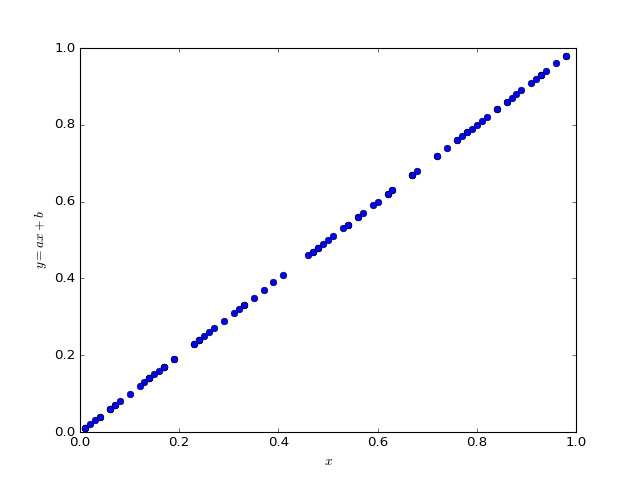

In [7]:
# Plot true data
plt.figure()
plt.plot(x_true, y_true, "bo")
plt.ylabel("$y = ax + b$")
plt.xlabel("$x$")

## 3. Simulate *Measured* Dataset

In reality each has an unknown error measurement,

$y_{data} = y_{true} + \epsilon_{y}$

$x_{data} = x_{true} + \epsilon_{x}$

In our example lets assume each error is independent for each measurement. So for each mesaurement:

* $\epsilon_x \in Norm[\mu=0, \sigma=u_x]$ -- i.e. $\epsilon_{x}$ is a draw from the uncertainty distribution of $x$
* $\epsilon_y \in Norm[\mu=0, \sigma=u_y]$ -- i.e. $\epsilon_{y}$ is a draw from the uncertainty distribution of $y$


Set uncertainties as:

* $u(x) = 0.05$
* $u(y) = 0.05$

In [8]:
# Define uncertainties
u_x = 0.05
u_y = 0.05

### ``i. Write a function to add errors to our data``

In [9]:
def add_errors(data, uncertainty):
    """
    Return array with independent random gaussian error each element
    
    :parameters:
    data (numpy.ndarray) - input array
    uncertainty (float) - random error gaussian standard deviation
    
    :return:
    data_error (numpy.ndarray) - input array + independent random gaussian errors
    """
    
    # Determine errors for each true value
    errors = np.random.normal(loc=0, scale=uncertainty, size=data.shape[0])
    
    # Add error to true data to
    data_error = data + errors
    
    return data_error

### ``ii. Simulate set of measured data by adding errors to true values``

In [12]:
# Add errors to true data to simulate set of "measured data"
x_data = add_errors(x_true, u_x)
y_data = add_errors(y_true, u_y)

### ``iii. Plot measured dataset``

<IPython.core.display.Javascript object>


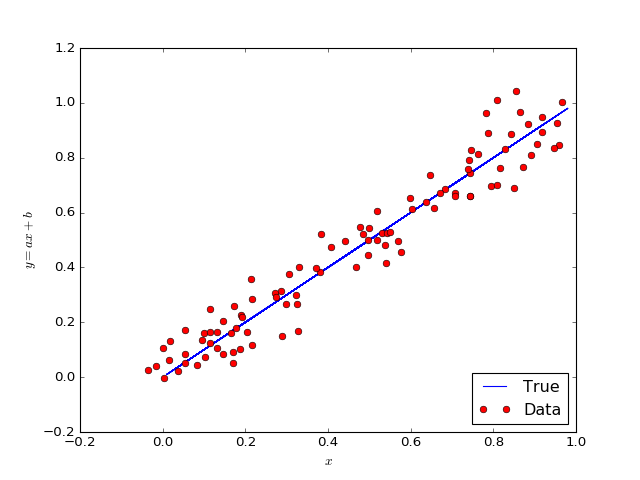

In [13]:
# Plot results
plt.figure()

# a. True data line
plt.plot(x_true, y_true, 'blue', label="True")

# b. Plot measured data points (with errorbars)
plt.plot(x_data, y_data, "ro", label="Data")

plt.ylabel("$y = ax + b$")
plt.xlabel("$x$")
plt.legend(loc=4)

## 4. Fitting the Data

In this section we will attempt to fit the measured data we produced in *Section 3* with two difference approaches, standard *Least Squares* (LSQ) or a more metrologically rigorous *Errors-in-Variables* (EIV) approach.

**a. Least Squares (LSQ)**

*Least Squares* optimisation fits based on weighting of uncertainties in $y$ dimension only, i.e,

<IPython.core.display.Javascript object>


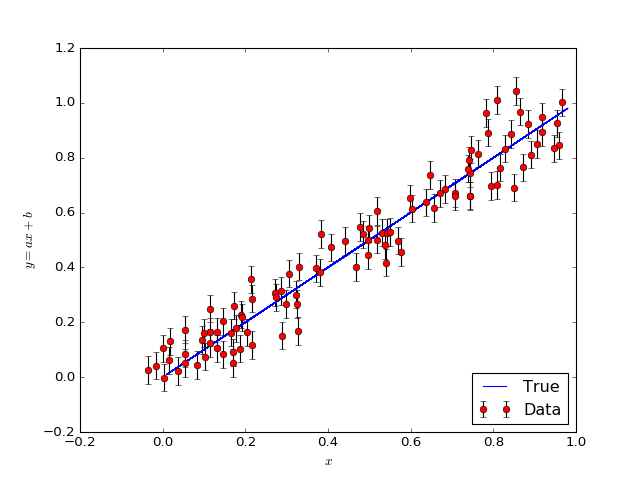

In [38]:
# Plot LSQ uncertainty picture
plt.figure()

# a. True data line
plt.plot(x_true, y_true, 'blue', label="True")

# b. Plot measured data points (with y errorbars)
plt.errorbar(x=x_data, y=y_data, yerr=u_y, fmt="ro", ecolor='black', label="Data")

plt.ylabel("$y = ax + b$")
plt.xlabel("$x$")
plt.legend(loc=4)

### ``i. Define function to perform Least Squares fitting.``

In [39]:
# Use scipy LSQ implementation curve_fit

def fit_lsq(measurement_function, x_data, y_data, u_y, p_initial):
    """
    Return optimised parameters for a given measurement function and input data
    
    :parameters:
    measurement_function (func) - measurement function
    x_data (numpy.ndarray) - input x data
    y_data (numpy.ndarray) - input y data
    u_y (float) - y data uncertainty
    p_initial (list) - intial parameter estimates
    
    :return:
    p_est (list) - optimised parameter estimates
    p_cov (numpy.ndarray) - parameter covariance matrix
    """

    p_est, p_cov = curve_fit(measurement_function, x_data, y_data, p_initial, u_y)

    return p_est, p_cov

### ``ii. Run optimisation``

In [40]:
# Run optimisation
p_lsq, cov_lsq = fit_lsq(measurement_function, x_data, y_data, u_y, p_initial=[0.0, 0.0])

a_lsq = p_lsq[0]
b_lsq = p_lsq[1]

# Print result
print "LSQ Parameter Estimate:"
print "a =", a_lsq
print "b =", b_lsq
print "\nCovariance matrix:"
print cov_lsq

LSQ Parameter Estimate:
a = 0.96160001166
b = 0.0231778705159

Covariance matrix:
[[ 0.00064611 -0.0002968 ]
 [-0.0002968   0.00019451]]


### ``iii. Plot results``

<IPython.core.display.Javascript object>


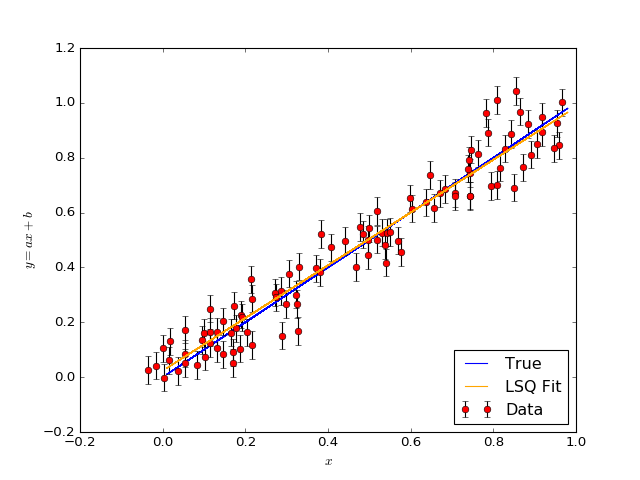

In [41]:
# Plot results
plt.figure()

# a. True calibration line
plt.plot(x_true, y_true, 'blue', label="True")

# b. Plot measured data points
plt.errorbar(x=x_data, y=y_data, yerr=u_y, fmt="ro", ecolor="black", label="Data")

#c. Plot estimate
y_lsq = measurement_function(x_true, a_lsq, b_lsq)
plt.plot(x_true, y_lsq, 'orange', label="LSQ Fit")

plt.ylabel("$y = ax + b$")
plt.xlabel("$x$")
plt.legend(loc=4)

**b. Errors in Variables**

*Errors-in-Variables* optimisation methods weight based on uncertainties in *both* the $x$ and $y$ dimension, i.e,

<IPython.core.display.Javascript object>


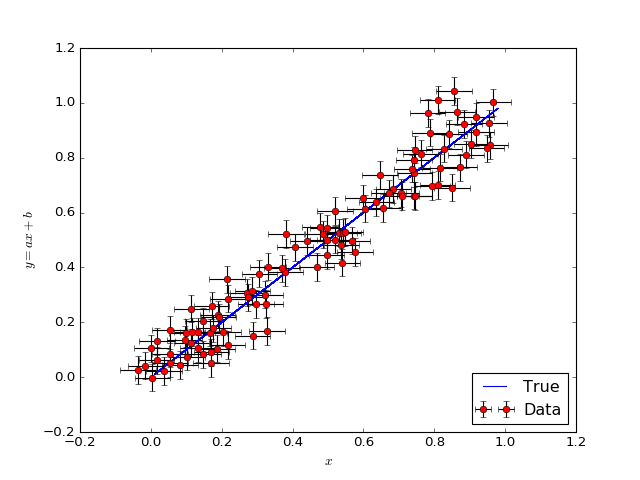

In [42]:
# Plot EIV uncertainty picture
plt.figure()

# a. True data line
plt.plot(x_true, y_true, 'blue', label="True")

# b. Plot measured data points (with errorbars)
plt.errorbar(x=x_data, xerr=u_x, y=y_data, yerr=u_y, fmt="ro", ecolor='black', label="Data")

plt.ylabel("$y = ax + b$")
plt.xlabel("$x$")
plt.legend(loc=4)

### ``i. Define function to perform Errors-in-Variables fitting``


Othogonal Distance Regression (ODR) is one implementation of *Errors-in-Variables* - use that here to estimate parameters.

In [43]:
# Use scipy ODRPACK implementation 

def fit_eiv(measurement_function, x_data, y_data, u_x, u_y, p_initial):
    """
    Return optimised parameters for a given measurement function and input data
    
    :parameters:
    measurement_function (func) - measurement function
    x_data (numpy.ndarray) - input x data
    y_data (numpy.ndarray) - input y data
    u_y (float) - x data uncertainty
    u_y (float) - y data uncertainty
    p_initial (list) - intial parameter estimates
    
    :return:
    p_est (list) - optimised parameter estimates
    p_cov (numpy.ndarray) - parameter covariance matrix
    """

    odr = ODR(RealData(x=x_data, y=y_data, sx=u_x, sy=u_y), Model(measurement_function), beta0=p_initial)
    result = odr.run()

    p_est = result.beta
    p_cov = result.cov_beta

    return p_est, p_cov

### ``ii. Run optimisation``

In [44]:
# scipy ODRPACK needs a slightly different form of input to the measurement function
def measurement_function_odr(p, x):
    return p[0] * x + p[1]

# Run optimisation
p_eiv, cov_eiv = fit_eiv(measurement_function_odr, x_data, y_data, u_x, u_y, p_initial=[0.0, 0.0])
a_eiv = p_eiv[0]
b_eiv = p_eiv[1]

# Print result
print "EIV Parameter Estimate:"
print "a =", a_eiv
print "b =", b_eiv
print "\nCovariance matrix:"
print cov_eiv

EIV Parameter Estimate:
a = 0.993775042771
b = 0.00839785117289

Covariance matrix:
[[ 0.00056091 -0.00025766]
 [-0.00025766  0.00016805]]


### ``iii. Plot results``

<IPython.core.display.Javascript object>


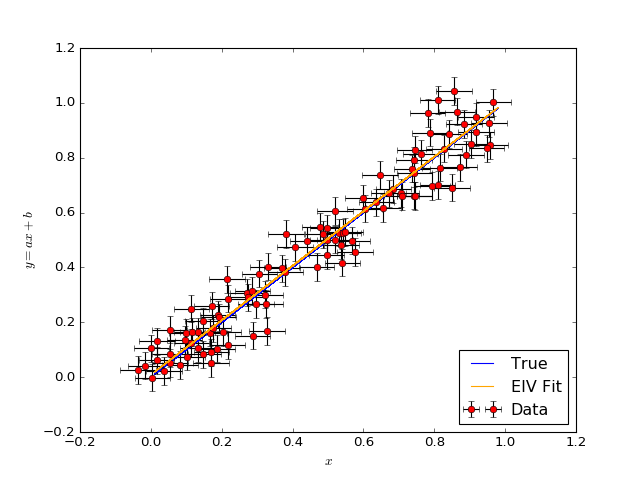

In [45]:
# Plot results
plt.figure()

# a. True calibration line
plt.plot(x_true, y_true, 'blue', label="True")

# b. Plot measured data points
plt.errorbar(x=x_data, y=y_data, xerr=u_x, yerr=u_y, fmt="ro", ecolor="black", label="Data")

#c. Plot EIV estimate
y_eiv = measurement_function(x_true, a_eiv, b_eiv)
plt.plot(x_true, y_eiv, 'orange', label="EIV Fit")

plt.ylabel("$y = ax + b$")
plt.xlabel("$x$")
plt.legend(loc=4)

## 5. How well does each perform

Perform Monte Carlo analysis of fitting approaches:
1. Generate ``n_trials`` instances of measured data, each with different random errors
2. Fit each iteration of with both *Least Squares* and *Errors-in-Variables* approaches
3. Compare results

### ``i. Perform Monte Carlo analysis``

In [34]:
# Define number of trials to perform
n_trials = 1000

# Initialise arrays to store parameter results 
a_lsqs = np.zeros(n_trials)
b_lsqs = np.zeros(n_trials)

a_eivs = np.zeros(n_trials)
b_eivs = np.zeros(n_trials)

y0_lsqs = np.zeros(n_trials)
y0_eivs = np.zeros(n_trials)

for i in range(n_trials):
    
    # Add errors to true data to generate set of "measured data"
    x_data_i = add_errors(x_true, u_x)
    y_data_i = add_errors(y_true, u_y)
    
    # Least squares fitting    
    p_lsq_i, cov_lsq_i = fit_lsq(measurement_function, x_data_i, y_data_i, u_y, p_initial=[0.0, 0.0])
    a_lsqs[i] = p_lsq_i[0]
    b_lsqs[i] = p_lsq_i[1]
    y0_lsqs[i] = measurement_function(x_true[0], a_lsqs[i], b_lsqs[i])
    
    # EIV fitting
    p_eiv_i, cov_eiv_i = fit_eiv(measurement_function_odr, x_data_i, y_data_i, u_x, u_y, p_initial=[0.0, 0.0])
    a_eivs[i] = p_eiv_i[0]
    b_eivs[i] = p_eiv_i[1]
    y0_eivs[i] = measurement_function(x_true[0], a_eivs[i], b_eivs[i])

### ``ii. Plot Outputs``

<IPython.core.display.Javascript object>


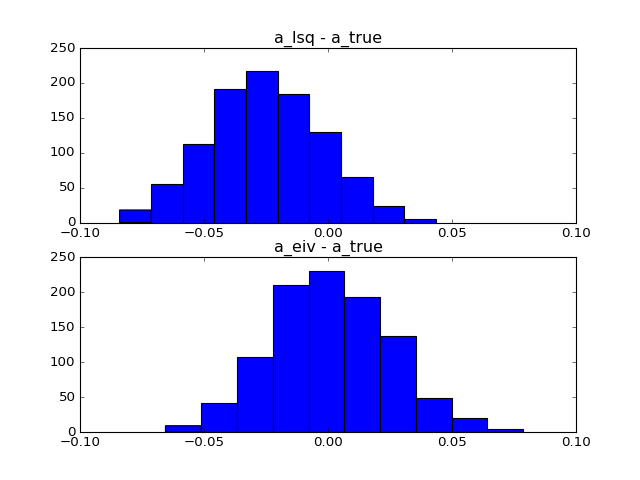

(-0.1, 0.1)

In [35]:
# Plot results for a parameter
plt.figure()

# a_lsq estimates
plt.subplot(2, 1, 1)
plt.hist(a_lsqs-a_true)
plt.title("a_lsq - a_true")
plt.xlim([-0.1, 0.1])

# a_eiv estimates
plt.subplot(2, 1, 2)
plt.hist(a_eivs-a_true)
plt.title("a_eiv - a_true")
plt.xlim([-0.1, 0.1])

<IPython.core.display.Javascript object>


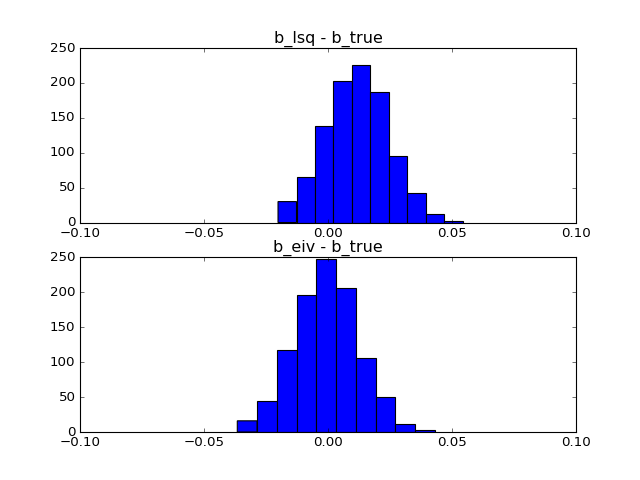

(-0.1, 0.1)

In [36]:
# Plot results for b parameter
plt.figure()

# a_lsq estimates
plt.subplot(2, 1, 1)
plt.hist(b_lsqs-b_true)
plt.title("b_lsq - b_true")
plt.xlim([-0.1, 0.1])

# a_eiv estimates
plt.subplot(2, 1, 2)
plt.hist(b_eivs-b_true)
plt.title("b_eiv - b_true")
plt.xlim([-0.1, 0.1])

<IPython.core.display.Javascript object>


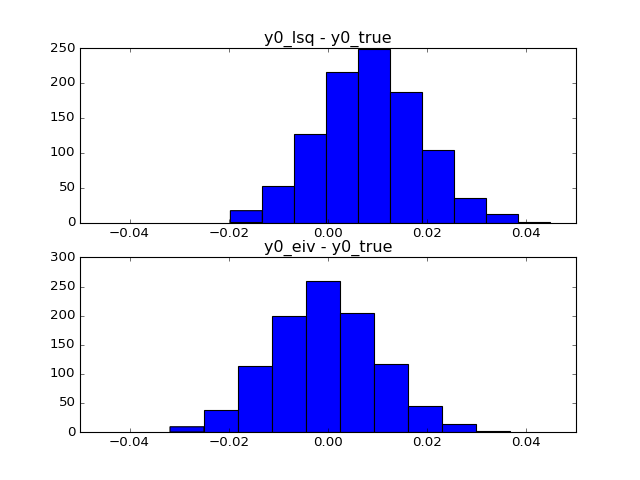

(-0.05, 0.05)

In [37]:
# Plot results of impact on a given y

# Compare results for b
plt.figure()

# a_lsq estimates
plt.subplot(2, 1, 1)
plt.hist(y0_lsqs-y_true[0])
plt.title("y0_lsq - y0_true")
plt.xlim([-0.05, 0.05])

# a_eiv estimates
plt.subplot(2, 1, 2)
plt.hist(y0_eivs-y_true[0])
plt.title("y0_eiv - y0_true")
plt.xlim([-0.05, 0.05])